In [5]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from scipy import optimize

In [6]:
class Rosenbrock:
    area = np.asarray([[-2.0, 2.0], [-1.0, 3.0]])
    min = np.asarray([[1.0, 1.0]])
    
    def objective(x):
        return 100 * (x[1] - x[0]**2)**2 + (1 - x[0])**2

In [7]:
class Himmelblau:
    area = np.asarray([[-4.0, 4.0], [-4.0, 4.0]])
    min = np.asarray([[3.0, 2.0], [-2.805118, 3.131312], [-3.779310, -3.283186], [3.584428, -1.848126]])
    
    def objective(x):
        return (x[0]**2 + x[1] - 11)**2 + (x[0] + x[1]**2 - 7)**2

In [43]:
class Particle:
    def __init__(self, objective, area, a_ind, a_grp, w):
        self.objective = objective
        self.area = area
        self.limits = np.swapaxes(area, 0, 1)

        self.w = w
        self.a_ind = a_ind #w * (np.random.rand(area.shape[0]) * 2.0 - np.ones(area.shape[0])) # np.random.rand()
        self.a_grp = a_grp

        self.p = area[:, 0] + np.random.rand(area.shape[0]) * (area[:, 1] - area[:, 0])
        

        self.v = np.random.rand(self.area.shape[0]) * 2.0 - np.ones(self.area.shape[0])
        self.v = self.w * self.v / np.linalg.norm(self.v)

        self.p_best = self.p_best_neigh = self.p

        self.f_best = objective(self.p)
        self.f_best_neigh = self.f_best


    def update(self, r_grp): #i
        r_ind = np.random.rand() # changes every iteration
        
        #print("prior:", self.w * self.v,
        #      "ind:" , self.a_ind * r_ind * (self.p_best - self.p),
        #      "grp:" , self.a_grp * r_grp * (self.p_best_neigh - self.p))
        self.v = (self.w * self.v
                + self.a_ind * r_ind * (self.p_best - self.p)
                + self.a_grp * r_grp * (self.p_best_neigh - self.p)
                )
        
        self.p += self.v
        self.p = np.clip(self.p, self.limits[0], self.limits[1])
        
        
        #print("pos:", self.p)
   
    def eval(self):
        f = self.objective(self.p)
        if f < self.f_best: # <, >
            self.p_best = self.p
            self.f_best = f
        if f < self.f_best_neigh: # <, >
            self.p_best_neigh = self.p
            self.f_best_neigh = f
        return self.p, f

In [31]:
#p = np.array([-5, 8])
#area = np.array([[-1, 1], [-1, 7]])
#limits = np.swapaxes(area, 0, 1)
#p = np.clip(p, limits[0], limits[1])
#print(p)

In [44]:
def particle_swarm_optimization(m, objective, area, iterations, w):
    a_ind = w #np.random.rand()
    a_grp = w # np.random.rand() 
    particles = [Particle(objective, area, a_ind, a_grp, w) for _ in range(m)]
    
    p_best_neigh = particles[0].p_best
    f_best_neigh = particles[0].f_best
    for particle in particles:
        if particle.f_best < f_best_neigh: # <, >
            p_best_neigh = particle.p_best_neigh
            f_best_neigh = particle.f_best_neigh

    history = np.zeros((m, iterations, area.shape[0]))
    
    for i in range(1, iterations):
        for j, particle in enumerate(particles):
            particle.p_best_neigh = p_best_neigh
            particle.f_best_neigh = f_best_neigh
            
            r_grp = np.random.rand() #w * (np.random.rand(area.shape[0]) * 2.0 - np.ones(area.shape[0]))
            particle.update(r_grp)
            p, f = particle.eval()
            history[j, i] = p
            if f < f_best_neigh: # <, >
                p_best_neigh = np.copy(p) # <---
                f_best_neigh = np.copy(f) # <---
                #history = np.concatenate((history, [p_best_neigh]), axis=0) # <---
    return p_best_neigh, f_best_neigh, history

In [60]:
np.random.seed(10) # randomize seed

# define testfunction, objective, area
test_function = Himmelblau

objective = test_function.objective
area = test_function.area
min = test_function.min

iterations = 50
m = 5
w = 0.5

p_best, f_best, history = particle_swarm_optimization(m, objective, area, iterations, w)

In [61]:
history.shape

(2, 50, 2)

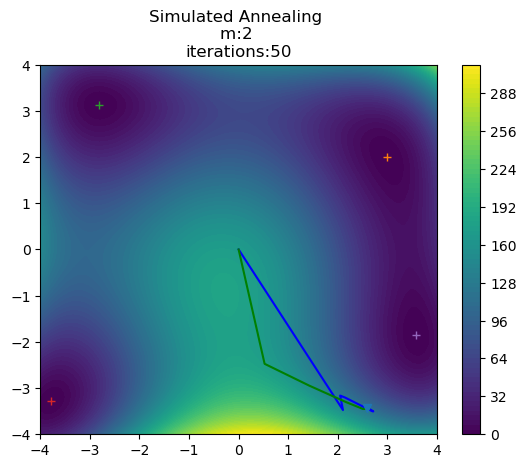

In [62]:
resolution = 100
xlist = np.linspace(area[0, 0], area[0, 1], resolution)
ylist = np.linspace(area[1, 0], area[1, 1], resolution)
X, Y = np.meshgrid(xlist, ylist)
I = np.stack([X, Y], axis=-1)

Z = np.zeros((resolution, resolution))
Z = np.apply_along_axis(objective, -1, I)

fig , ax = plt.subplots(1,1)

cp = ax.contourf(X, Y, Z, levels = 100)
fig.colorbar(cp) # Add a colorbar to a plot
'''
    b: blue
    g: green
    r: red
    c: cyan
    m: magenta
    y: yellow
    k: black
    w: white
'''
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
for i, particle_h in enumerate(history):
    ax.plot(particle_h.T[0], particle_h.T[1], colors[i])
ax.plot(p_best[0], p_best[1], 'v')
for el in min:
    ax.plot(el[0], el[1], '+')
ax.set_title(f'Simulated Annealing \nm:{m} \niterations:{iterations}')
plt.show()

In [20]:
p_best,f_best

(array([-3.78430095, -3.29000714]), 0.0018597261452805804)

In [21]:
idx = np.linalg.norm(min - p_best, axis = 1).argmin()
print(np.linalg.norm(min[idx] - p_best))

0.008452075132781142
